# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from os import listdir
from PIL import Image
from numpy import asarray
from os.path import dirname, join as pjoin
import scipy.io as sio
import json
import time
import cv2
import matplotlib.cm as cm
from tensorflow.keras.applications.vgg16 import preprocess_input
from skimage.transform import resize

## UCSD Dataset

UCSD dataset consists of an hour of video with 2000 annotated frames and in a total of 49,885 pedestrian
instances, which was captured from a pedestrian walkway of the UCSD campus by a stationary camera. The original video was recorded at 30fps with a frame size of 480 × 740 and later downsampled to 10fps with dimension 158×238. The 601-1400 frames were used for training and the remaining 1200 frames for testing. 
The ROI of the walkway and the traveling direction are
also provided.

It is taken from http://www.svcl.ucsd.edu/projects/peoplecnt/

### Images

Because the resolution of each frame is fixed and small (238 × 158), it is difficult to generate a high-quality density map after frequent pooling operations. So we preprocess the frames by using bilinear interpolation to resize them into 952 × 632.

In [2]:
def load_dataset_unpooling(path_vidf):
    
    full_lista = []
    output_shape = (632,952)
    
    for path in os.listdir(path_vidf):
        
        lista_images=[]

        # Append images to a list
        for item in os.listdir(path_vidf+path+"/"):
            if os.path.isfile(path_vidf+path+"/"+item):
                im = Image.open(path_vidf+path+"/"+item).convert("RGB")
                im = np.array(im)
                
                # Perform unpooling with bilinear interpolation
                unpooled_image = resize(im, output_shape, mode="reflect", anti_aliasing=True)
                
                lista_images.append(unpooled_image)
        full_lista.append(np.array(lista_images))
            
    return full_lista

In [3]:
UCSD_dataset_resize = load_dataset_unpooling("UCSDpeds/ucsdpeds/vidf/")

In [4]:
UCSD_dataset_resize[0].shape

(200, 632, 952, 3)

In [5]:
# Convert and save the list of images in '.npy' format

np.save("test_UCSD_resize0.npy", UCSD_dataset_resize[0])
np.save("test_UCSD_resize1.npy", UCSD_dataset_resize[1])
np.save("test_UCSD_resize2.npy", UCSD_dataset_resize[2])
np.save("train_UCSD_resize3.npy", UCSD_dataset_resize[3])
np.save("train_UCSD_resize4.npy", UCSD_dataset_resize[4])
np.save("train_UCSD_resize5.npy", UCSD_dataset_resize[5])
np.save("train_UCSD_resize6.npy", UCSD_dataset_resize[6])
np.save("test_UCSD_resize7.npy", UCSD_dataset_resize[7])
np.save("test_UCSD_resize8.npy", UCSD_dataset_resize[8])
np.save("test_UCSD_resize9.npy", UCSD_dataset_resize[9])

In [6]:
images_UCSD_resize0 = np.load("test_UCSD_resize0.npy")
images_UCSD_resize0.shape

(200, 632, 952, 3)

### Ground truth

In [8]:
# ground truth

gt_UCSD0 = sio.loadmat("UCSD_ground_truth/vidf1_33_000_frame_full.mat")
gt_UCSD1 = sio.loadmat("UCSD_ground_truth/vidf1_33_001_frame_full.mat")
gt_UCSD2 = sio.loadmat("UCSD_ground_truth/vidf1_33_002_frame_full.mat")
gt_UCSD3 = sio.loadmat("UCSD_ground_truth/vidf1_33_003_frame_full.mat")
gt_UCSD4 = sio.loadmat("UCSD_ground_truth/vidf1_33_004_frame_full.mat")
gt_UCSD5 = sio.loadmat("UCSD_ground_truth/vidf1_33_005_frame_full.mat")
gt_UCSD6 = sio.loadmat("UCSD_ground_truth/vidf1_33_006_frame_full.mat")
gt_UCSD7 = sio.loadmat("UCSD_ground_truth/vidf1_33_007_frame_full.mat")
gt_UCSD8 = sio.loadmat("UCSD_ground_truth/vidf1_33_008_frame_full.mat")
gt_UCSD9 = sio.loadmat("UCSD_ground_truth/vidf1_33_009_frame_full.mat")

### Labels

In [9]:
def read_mat_label(path):
    labels=[]
    for item in os.listdir(path):
        if os.path.isfile(path+item) & (item.endswith(".mat")):
            dict_label = sio.loadmat(path+item)
            labels.append(dict_label["count"])
    counts = [np.sum(labels[i], axis=1)[0] for i in range(len(labels))]  # sum of right and left counts
    return counts

In [ ]:
labels_UCSD = read_mat_label("UCSD_labels/vidf-cvpr/")

In [ ]:
# Convert and save the list of images in '.npy' format
np.save("labels_UCSD.npy", labels_UCSD)

In [10]:
labels_UCSD = np.load("labels_UCSD.npy")
labels_UCSD.shape

(10, 1, 200)

## Density function - 1/8 resolution

We will start from original size images and resize all dividing by 2, so that our density images will be 1/8 of the unpooled images.

In [11]:
# load original images
images_UCSD = np.load("images_UCSD.npy")
images_UCSD.shape

(10, 200, 158, 238, 3)

In [12]:
def load_dataset_resize(path_vidf):
    
    full_lista = []
    
    for path in os.listdir(path_vidf):
        
        lista_images=[]

        # Append images to a list
        for item in os.listdir(path_vidf+path+"/"):
            if os.path.isfile(path_vidf+path+"/"+item):
                im = Image.open(path_vidf+path+"/"+item).convert("RGB")
                new_image = im.resize((238//2, 158//2))
                im = np.array(new_image)
                lista_images.append(im)
        full_lista.append(np.array(lista_images))
            
    return full_lista

In [13]:
UCSD_dataset_low = load_dataset_resize("UCSDpeds/ucsdpeds/vidf/")

In [14]:
# Convert and save the list of images in '.npy' format
np.save("images_UCSD_low.npy",UCSD_dataset_low)

In [15]:
images_UCSD_low = np.load("images_UCSD_low.npy")
images_UCSD_low.shape

(10, 200, 79, 119, 3)

In [16]:
def density_UCSD_low_resolution(folder, img_number, gt):

    '''
    Input:
    - folder: folder of the image
    - img_number: number of the image
    - gt: ground truth of img as dictionary

    '''

    output = np.zeros(images_UCSD_low[folder][img_number].shape[:-1])
    x_full = gt["frame"][0, img_number][0, 0][0][:,0]/2
    y_full = gt["frame"][0, img_number][0, 0][0][:,1]/2

    '''
    # for high number of persons
    for x, y in zip(x_full, y_full):
        density_img = np.zeros(dataset[folder][img_number].shape[:-1])
        try:
            density_img[round(y),round(x)] = 1
        except:
            pass
        nearest_distance = np.min(np.linalg.norm(x - y))
        sigma = 0.3 * nearest_distance # beta = 0.3 suggested by MCNN paper
        kernel_size = 3

        density_img = cv2.GaussianBlur(density_img, (kernel_size,kernel_size), sigma)
        output += density_img
    '''
    
    for x, y in zip(x_full, y_full):
        density_img = np.zeros(images_UCSD_low[folder][img_number].shape[:-1])
        try:
            density_img[round(y), round(x)] = 1
        except:
            pass

        sigma = 3 
        kernel_size = 3

        density_img = cv2.GaussianBlur(density_img, (kernel_size,kernel_size), sigma)
        output += density_img 

    return cv2.GaussianBlur(output, (11,11), sigma)

Time: 0.0236208438873291


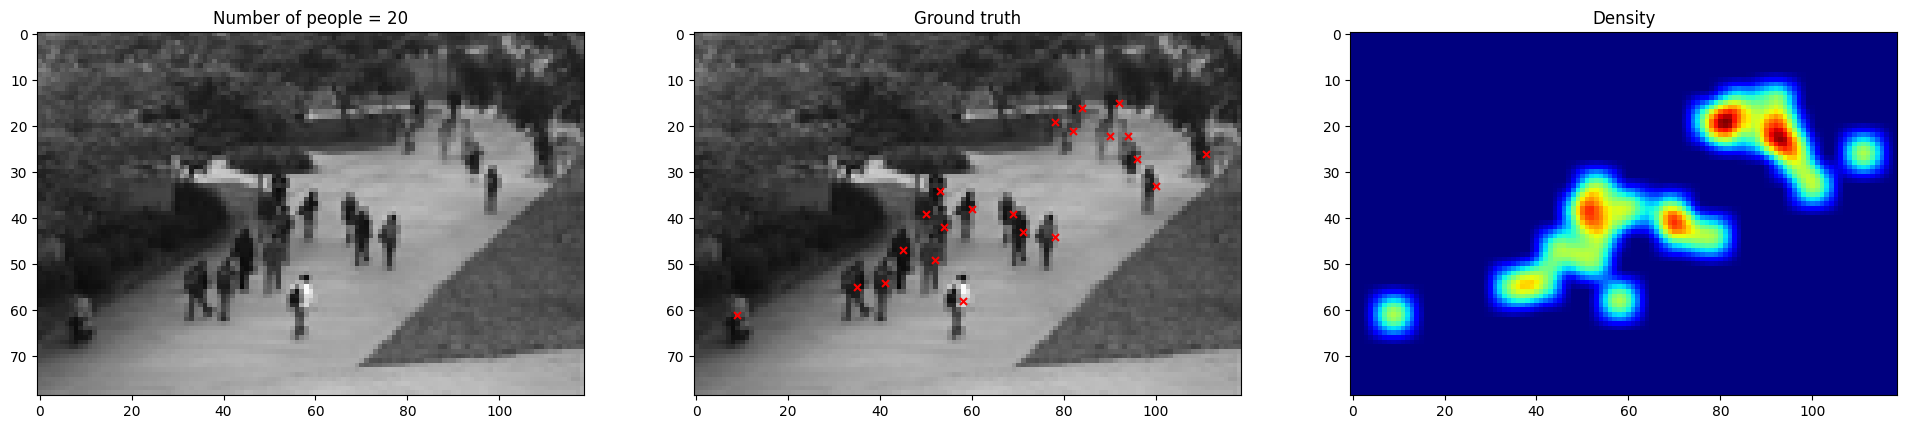

In [17]:
# density map on first image from folder 1 of UCSD dataset

start = time.time()
ds = density_UCSD_low_resolution(folder=1, img_number=0, gt=gt_UCSD1)
print(f"Time: {time.time() - start}")

plt.figure(figsize=(24, 9))

#image with label
plt.subplot(1, 3, 1)
plt.imshow(images_UCSD_low[1][0])
plt.title(f"Number of people = {labels_UCSD[1][0,0]}")

# image with ground truth
plt.subplot(1, 3, 2)
plt.imshow(images_UCSD_low[1][0])
for x,y in gt_UCSD1["frame"][0, 0][0, 0][0][:,0:2]/2:
    plt.scatter(round(x),round(y), s = 25, marker = "x", color = "r")
plt.title("Ground truth")

# image with density map
plt.subplot(1, 3, 3)
plt.imshow(ds, cmap = cm.jet)
_ = plt.title("Density")

### Density images

In [18]:
dens_images_UCSD_resize = []
list_ground_truth = [gt_UCSD0, gt_UCSD1,gt_UCSD2, gt_UCSD3, gt_UCSD4, 
                     gt_UCSD5, gt_UCSD6, gt_UCSD7, gt_UCSD8, gt_UCSD9]

for folder, gt in enumerate(list_ground_truth):
    for img in range(images_UCSD_low.shape[1]):
        dens_images_UCSD_resize.append(density_UCSD_low_resolution(folder, img, gt))

In [19]:
# Convert and save the list of images in '.npy' format
np.save("density_UCSD_resize.npy", dens_images_UCSD_resize)

In [20]:
density_UCSD_resize = np.load("density_UCSD_resize.npy")
density_UCSD_resize.shape

(2000, 79, 119)

## Train and test

We use frames from 601 to 1400 as training data, and the remaining 1200 frames as testing data. The training data correspond to folders from 3 to 6.

In [2]:
# training images

train_UCSD_resize3 = np.load("train_UCSD_resize3.npy")
train_UCSD_resize4 = np.load("train_UCSD_resize4.npy")
train_UCSD_resize5 = np.load("train_UCSD_resize5.npy")
train_UCSD_resize6 = np.load("train_UCSD_resize6.npy")

train_UCSD_resize3.shape

In [4]:
# training densities

dens_train = density_UCSD_resize[601:1401]
dens_train.shape

(800, 79, 119)

In [5]:
# testing densities

dens_test1 = density_UCSD_resize[:601]
dens_test2 = density_UCSD_resize[1401:]
print(dens_test1.shape)
print(dens_test2.shape)

(601, 79, 119)
(599, 79, 119)


In [6]:
np.save("dens_train_UCSD_resize.npy", dens_train)
np.save("dens_test1_UCSD_resize.npy", dens_test1)
np.save("dens_test2_UCSD_resize.npy", dens_test2)

In [7]:
density_train_UCSD_resize = np.load("dens_train_UCSD_resize.npy")
density_train_UCSD_resize.shape

(800, 79, 119)

In [8]:
density_test1_UCSD_resize = np.load("dens_test1_UCSD_resize.npy")
density_test1_UCSD_resize.shape

(601, 79, 119)

In [9]:
density_test2_UCSD_resize = np.load("dens_test2_UCSD_resize.npy")
density_test2_UCSD_resize.shape

(599, 79, 119)

## Preprocessing for VGG16

In [10]:
# Preprocess data for vgg16 -train folder 3

prepro_list = []

for img in train_UCSD_resize3:
    prepro_img = preprocess_input(img)
    prepro_list.append(prepro_img)

prepro_train3 = np.array(prepro_list)
prepro_train3.shape

(200, 632, 952, 3)

In [11]:
np.save("prepro_train3_UCSD.npy", prepro_train3)

In [12]:
prepro_train3_UCSD = np.load("prepro_train3_UCSD.npy")
prepro_train3_UCSD.shape

(200, 632, 952, 3)

In [13]:
# Preprocess data for vgg16 -train folder 4

prepro_list = []

for img in train_UCSD_resize4:
    prepro_img = preprocess_input(img)
    prepro_list.append(prepro_img)

prepro_train4 = np.array(prepro_list)
prepro_train4.shape

(200, 632, 952, 3)

In [14]:
np.save("prepro_train4_UCSD.npy", prepro_train3)

In [15]:
prepro_train4_UCSD = np.load("prepro_train4_UCSD.npy")
prepro_train4_UCSD.shape

(200, 632, 952, 3)

In [16]:
# Preprocess data for vgg16 -train folder 5

prepro_list = []

for img in train_UCSD_resize5:
    prepro_img = preprocess_input(img)
    prepro_list.append(prepro_img)

prepro_train5 = np.array(prepro_list)
prepro_train5.shape

(200, 632, 952, 3)

In [17]:
np.save("prepro_train5_UCSD.npy", prepro_train5)

In [18]:
prepro_train5_UCSD = np.load("prepro_train5_UCSD.npy")
prepro_train5_UCSD.shape

(200, 632, 952, 3)

In [19]:
# Preprocess data for vgg16 -train folder 6

prepro_list = []

for img in train_UCSD_resize6:
    prepro_img = preprocess_input(img)
    prepro_list.append(prepro_img)

prepro_train6 = np.array(prepro_list)
prepro_train6.shape

(200, 632, 952, 3)

In [20]:
np.save("prepro_train6_UCSD.npy", prepro_train6)

In [21]:
prepro_train6_UCSD = np.load("prepro_train6_UCSD.npy")
prepro_train6_UCSD.shape

(200, 632, 952, 3)

In [3]:
# Preprocess data for vgg16 -test folder 0
prepro_list = []

for img in test_UCSD_resize0:
    prepro_img = preprocess_input(img)
    prepro_list.append(prepro_img)

prepro_test0 = np.array(prepro_list)
np.save("prepro_test0_UCSD.npy", prepro_test0)
prepro_test0.shape

(200, 632, 952, 3)

In [4]:
# Preprocess data for vgg16 -test folder 1
prepro_list = []

for img in test_UCSD_resize1:
    prepro_img = preprocess_input(img)
    prepro_list.append(prepro_img)

prepro_test1 = np.array(prepro_list)
np.save("prepro_test1_UCSD.npy", prepro_test1)
prepro_test1.shape

(200, 632, 952, 3)

In [5]:
# Preprocess data for vgg16 -test folder 2
prepro_list = []

for img in test_UCSD_resize2:
    prepro_img = preprocess_input(img)
    prepro_list.append(prepro_img)

prepro_test2 = np.array(prepro_list)
np.save("prepro_test2_UCSD.npy", prepro_test2)
prepro_test2.shape

(200, 632, 952, 3)

In [6]:
# Preprocess data for vgg16 -test folder 7
prepro_list = []

for img in test_UCSD_resize7:
    prepro_img = preprocess_input(img)
    prepro_list.append(prepro_img)

prepro_test7 = np.array(prepro_list)
np.save("prepro_test7_UCSD.npy", prepro_test7)
prepro_test7.shape

(200, 632, 952, 3)

In [7]:
# Preprocess data for vgg16 -test folder 8
prepro_list = []

for img in test_UCSD_resize1:
    prepro_img = preprocess_input(img)
    prepro_list.append(prepro_img)

prepro_test8 = np.array(prepro_list)
np.save("prepro_test8_UCSD.npy", prepro_test8)
prepro_test8.shape

(200, 632, 952, 3)

In [8]:
# Preprocess data for vgg16 -test folder 9
prepro_list = []

for img in test_UCSD_resize9:
    prepro_img = preprocess_input(img)
    prepro_list.append(prepro_img)

prepro_test9 = np.array(prepro_list)
np.save("prepro_test9_UCSD.npy", prepro_test9)
prepro_test9.shape

(200, 632, 952, 3)

## Validation data
For the validation set we choose the last 80 frames of the training

In [9]:
prepro_val_UCSD_resize = prepro_train6_UCSD[120:]
np.save("prepro_val_UCSD_resize.npy", prepro_val_UCSD_resize)

In [10]:
prepro_train6_UCSD = prepro_train6_UCSD[:120]
np.save("prepro_train6_UCSD.npy", prepro_train6_UCSD)

In [11]:
dens_val_UCSD_resize = density_train_UCSD_resize[720:]
np.save("dens_val_UCSD_resize.npy", dens_val_UCSD_resize)

In [12]:
density_train_UCSD_resize = density_train_UCSD_resize[:720]
np.save("dens_train_UCSD_resize.npy", density_train_UCSD_resize)